In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt



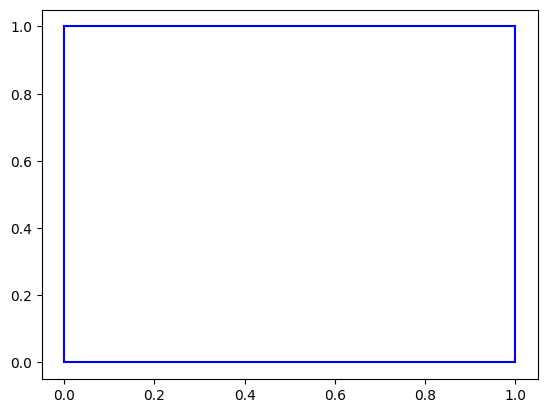

In [2]:
class Mesh:
  def __init__(self, edges: torch.Tensor):
    self.edges = edges
    self.edge_lens = torch.norm(edges[:,0] - edges[:,1], dim=1)
  
  def loop(vertices):
    edges = torch.cat([vertices[:-1], vertices[1:]],dim=1).reshape(-1, 2, 2)
    return Mesh(edges)
  
  def plot(self, c='b'):
    for edge in self.edges:
      plt.plot(*edge.T, c)
    
  def pointcloud(self,n=1000,std = 0.01):
    edges_probs = self.edge_lens/self.edge_lens.sum()
    edges = torch.multinomial(edges_probs, n, replacement=True)
    edges = self.edges[edges]
    t = torch.rand(n)
    points = edges[:,0] + t[:,None]*(edges[:,1]-edges[:,0])
    noise = torch.randn_like(points)*std
    return points + noise
  
box = Mesh.loop(torch.tensor([[0, 0], [0, 1], [1, 1],[1,0], [0,0]],dtype=torch.float32))
box.plot()

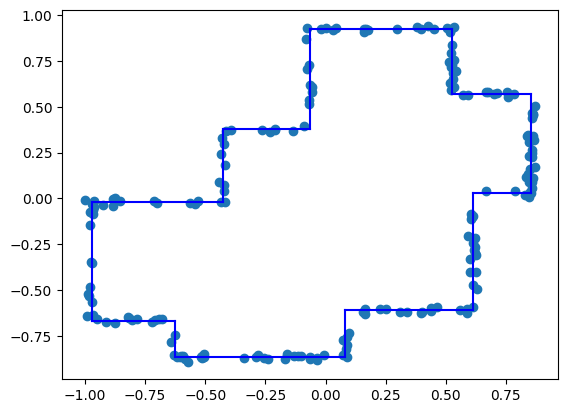

In [3]:
def random_shape():
  n = np.random.randint(3, 10)
  corners = []

  for i in range(n):
    angle = 2*np.pi*i/n + np.random.rand()*0.1
    r = np.random.rand() * 0.5 + 0.5
    corners.append(torch.tensor([np.cos(angle)*r, np.sin(angle)*r],dtype=torch.float32))

  verts = []
  corner_dir = np.random.randint(2)
  for i in range(n + 1):
    verts.append(corners[i % n])
    verts.append(torch.tensor([corners[(i+corner_dir) % n][0] , corners[(i + 1 - corner_dir) % n][1]]))

  return Mesh.loop(torch.stack(verts[:-1]))


shape = random_shape()
shape.plot()
v = shape.pointcloud(200)
plt.scatter(*v.T)


In [ ]:

def gen_data(n):
  train_shapes = [random_shape() for _ in range(n)]
  x = [s.pointcloud(100) for s in train_shapes]
  y = [s.edges for s in train_shapes]
  x = torch.stack(x)
  maxverts = max([len(x) for x in y])
  assert maxverts == 18 
  y = [torch.cat([y.reshape(-1,4), torch.ones(len(y), 1)], dim=1) for y in y]
  y = torch.stack([torch.cat([y, torch.zeros(maxverts - len(y), 5)]) for y in y])
  return x, y

In [ ]:

from torch.nn import TransformerEncoderLayer, Linear, Sequential
from torch.optim import Adam

output_dim = 18 * 5
hidden_dim = 512
nhead = 4
inducing_points = 18

class MAB(torch.nn.Module):
  def __init__(self, hidden_dim, nhead, dropout=0.1):
    super(MAB, self).__init__()
    self.attention = torch.nn.MultiheadAttention(hidden_dim, nhead, batch_first=True, dropout=dropout)
    self.norm = torch.nn.LayerNorm(hidden_dim)
    self.linear = Linear(hidden_dim, hidden_dim)
    
  def forward(self, q, kv): 
    x = self.attention(q, kv, kv)[0]
    x = self.norm(x)
    return self.linear(x).relu()

class Model(torch.nn.Module):
  def __init__(self, hidden_dim, nhead, k):
    super(Model, self).__init__()
    
    self.embedding = Linear(2, hidden_dim)
    self.mab1 = MAB(hidden_dim,nhead,dropout=0.1)
    self.mab2 = MAB(hidden_dim,nhead,dropout=0.1)
    self.mab3 = MAB(hidden_dim,nhead,dropout=0.1)
    self.mab4 = MAB(hidden_dim,nhead,dropout=0.1)
    self.adapter = Linear(hidden_dim, 5)
    self.inducing_points = torch.nn.Parameter(torch.randn(k, hidden_dim))
    self.norm = torch.nn.LayerNorm(hidden_dim)

  def forward(self, x):
    x = self.embedding(x)
    p = self.inducing_points.repeat(x.shape[0],1,1)

    p = self.mab1(p,x)
    p = self.mab2(p,p) + p
    p = self.mab3(p,x) + p
    p = self.mab4(p,p) + p

    p = self.adapter(p).reshape(-1,18,5)
    p[:,:,-1] = p[:,:,-1].sigmoid()
    return p

  def save(self, path): torch.save(self.state_dict(), path)
  def load(self, path): self.load_state_dict(torch.load(path))


x, y = gen_data(200)
model = Model(hidden_dim, nhead, inducing_points)
print(model(x[:2]).shape)
optimizer = Adam(model.parameters(), lr=0.0001)



In [ ]:
def loss_fn(p, y):
  p = p.reshape(-1,18,5)
  y = y.reshape(-1,18,5)

  new_y = torch.zeros_like(p)
  for i, (pshape, yshape) in enumerate(zip(p,y)):
    reordered_y = []
    for pedge in pshape:
      dists = torch.norm(pedge - yshape[:], dim=1)
      closest = dists.argmin()
      reordered_y.append(yshape[closest])
      yshape = torch.cat([yshape[:closest], yshape[closest+1:]])
    yshape = torch.stack(reordered_y)
    new_y[i] = yshape
  
  y = new_y
  mask = y[:,:,4:]
  pred_mask = p[:,:,4:]
  
  masked_dists = (p[:,:,:4] - y[:,:,:4])**2 * mask
  geom_loss = masked_dists.sum()/mask.sum()
  
  mask_loss = torch.nn.functional.binary_cross_entropy(pred_mask, mask, reduction='mean')
  return geom_loss + mask_loss, y

def step(x,y):
  optimizer.zero_grad()
  p = model(x)
  loss, reordered_y = loss_fn(p, y)
  loss.backward()
  optimizer.step()
  print(f'\rloss:{loss.item()}',end='')
  return p, reordered_y

def display(p,x,y):
  k = np.random.randint(0, len(x))
  p_edges = p[k].reshape(-1,5)[:,:4].reshape( 18, 2, 2)
  y_edges = y[k].reshape(-1,5)[:,:4].reshape( 18, 2, 2)
  pmask = p[k].reshape(-1,5)[:,4:].reshape( 18, 1)
  for edge, yedge in zip(p_edges, y_edges):
    if yedge.sum() != 0:
      plt.plot([edge[0,0], yedge[0,0]], [edge[0,1], yedge[0,1]], c='red')
      plt.plot([edge[1,0], yedge[1,0]], [edge[1,1], yedge[1,1]], c='red')

  for edge in y_edges: plt.plot(*edge.T, c='black')
  for edge,m in zip(p_edges,pmask): plt.plot(*edge.T, c=plt.colormaps['Blues'](m.item()))
  
  plt.scatter(*x[k].T, c='gray')

p,newy=step(x,y)
display(p.detach(),x,newy)


In [ ]:
try:
  for i in range(1000):
    x, y = gen_data(200)
    _,newy = step(x,y)
    if i % 10 == 0: print(f'\nepoch {i}')
except: pass

In [ ]:
display(p.detach(),x,newy)
p,newy=step(x,y)

In [ ]:
model.load('mab4model.pth')

In [ ]:

with torch.no_grad(): p = model.train(False).forward(x)
for _ in range(10):
  loss, newy = loss_fn(p, y)
  display(p,x,newy)
  plt.show()


In [ ]:

p = p.detach()
p.requires_grad = True


In [ ]:

def dist_mat(p,y):
  
  p = p.unsqueeze(2)
  y = y.unsqueeze(1)
  
  pmask = p[:,:,:,4].repeat(1,1,18)
  ymask = y[:,:,:,4].repeat(1,18,1)
  mask_dist = torch.nn.functional.binary_cross_entropy(pmask, ymask,reduction='none')

  dist = torch.norm (p[:,:,:,:4] - y[:,:,:,:4],dim=-1) * ymask + mask_dist
  dist = - dist * 10. # temperature hyperparameter
  dist = dist.softmax(2)
  
  for i in range(4):
    dist = dist / dist.sum(2, keepdim=True)
    dist = dist / dist.sum(1, keepdim=True)

  return dist
  
dist = dist_mat(p, y)
plt.imshow(dist[0].detach())

dist[0].sum(1).max()


In [ ]:
res_edges = p.unsqueeze(2) # 200, 18, 1, 5
res_edges = res_edges * dist.unsqueeze(3) # 200, 18, 18, 5
res_edges = res_edges.sum(1)


goal_edges = y.unsqueeze(1) # 200, 1, 18, 5
goal_edges = goal_edges * dist.unsqueeze(3) # 200, 18, 18, 5
goal_edges = goal_edges.sum(2)



In [ ]:

pedges = p[0,:,:4].reshape(-1,2,2).detach()
yedges = y[0,:,:4].reshape(-1,2,2)
pmask = p[0,:,4]
for edge in yedges: plt.plot(*edge.T, c='black')
for edge,m in zip(pedges,pmask): plt.plot(*edge.T, c=plt.colormaps['Blues'](m.item()))

goal_edges = goal_edges.detach()[0,:,:4].reshape(-1,2,2)
for edge, gedge in zip(pedges, goal_edges):
  plt.plot(*gedge.T, c='gray')
  plt.plot([edge[0,0], gedge[0,0]], [edge[0,1], gedge[0,1]], c='gray')
  plt.plot([edge[1,0], gedge[1,0]], [edge[1,1], gedge[1,1]], c='gray')


res_mask = res_edges[0,:,4]
res_edges = res_edges[0,:,:4].reshape(-1,2,2).detach()
for edge, m, yedge in zip(res_edges, res_mask, yedges):
  m = max(m,0.5)
  # plt.plot(*edge.T, c=plt.colormaps['Grays'](m.item()))
  # plt.plot([edge[0,0], yedge[0,0]], [edge[0,1], yedge[0,1]], c='gray')
  # plt.plot([edge[1,0], yedge[1,0]], [edge[1,1], yedge[1,1]], c='gray')
